# Sistema Multi-Robôs para Cobertura Eficiente de Ambientes Domésticos

- Bernardo Nogueira Borges
- Daniele Cássia Silva Diniz

Uma aplicação relevante na área de robótica é a dos robôs aspiradores, que têm a
função de percorrer o ambiente doméstico de forma autônoma, recolhendo detritos
ao longo do caminho. Este projeto abordará o problema de cobertura no contexto de
sistemas multi-robôs, com o objetivo de dividir a tarefa entre dois robôs. Um dos
principais desafios nesta área é garantir que os robôs executem seu trajeto de forma
eficiente, evitando a movimentação aleatória pelo espaço, como observado em
robôs aspiradores convencionais, conforme demonstrado no [vídeo](https://www.youtube.com/watch?v=qHEJhJ_CuOQ) da Neato
Robotics

Para superar esses desafios, utilizaremos nosso conhecimento em mapeamento,
controle e algoritmos para desenvolver um sistema de multi-robôs que abordará o
problema de **cobertura** do ambiente de forma eficaz, completa e, adicionalmente,
enfrentaremos o desafio de implementar a colaboração entre os robôs. A
implementação será realizada utilizando a linguagem **Python** e o simulador
**CoppeliaSim**.

Abordar este problema é crucial para aumentar a eficiência energética e reduzir a
pegada de carbono dos robôs aspiradores domésticos. Um planejamento adequado
permite que esses robôs executem suas tarefas de maneira mais rápida e eficiente,
contribuindo significativamente para a sustentabilidade ambiental. As principais
aplicações incluem a limpeza autônoma em residências, escritórios e outros
espaços fechados onde a manutenção regular é necessária.

In [366]:
from coppeliasim_zmqremoteapi_client import RemoteAPIClient
import numpy as np
import matplotlib.pyplot as plt

client = RemoteAPIClient()
sim = client.require('sim')
np.set_printoptions(precision=3,suppress=True)

## Obtendo o Mapa da Residência

## Colored Planner

In [356]:
from enum import Enum


class Color(Enum):
    UNSET = 0
    RED = 1
    BLUE = 2


#          UP     RIGHT    DOWN   LEFT
moves = [(-1, 0), (0, 1), (1, 0), (0, -1)]


def validCell(i, j, G):
    N = len(G)
    M = len(G[0])
    return 0 <= i < N \
        and 0 <= j < M \
        and G[i][j] == 0

def bfs_multi(blue_src, red_src, G):
    COLOR_GRAPH = np.zeros(shape=G.shape)

    q = [blue_src, red_src]
    while q:
        (i, j, c) = q.pop(0)

        if COLOR_GRAPH[i][j] != Color.UNSET.value:
            continue

        COLOR_GRAPH[i][j] = c.value

        # Each cell 4-Connect
        for (di, dj) in moves:
            di += i
            dj += j

            # Out of bounds
            if not validCell(di, dj, G):
                continue

            # Already visited
            if COLOR_GRAPH[di][dj] != Color.UNSET.value:
                continue

            q.append((di, dj, c))

    return COLOR_GRAPH


def colorize(G):
    N = len(G)
    M = len(G[0])
    blue_src = None
    for i in range(N):
        for j in range(M):
            if G[i][j] == 0:
                blue_src = (i, j, Color.BLUE)
                break
        if blue_src != None:
            break

    if blue_src == None:
        print("Could not find a blue_src")
        return

    red_src = None
    for i in reversed(range(N)):
        for j in reversed(range(M)):
            if G[i][j] == 0 and (i, j) != (blue_src[0], blue_src[1]):
                red_src = (i, j, Color.RED)
                break
        if red_src != None:
            break

    if red_src == None:
        print("Could not find a red_src")
        return

    return bfs_multi(blue_src, red_src, G)


def plot_color_graph(CG):
    N = len(CG)
    M = len(CG[0])

    # Create a colormap with specified colors
    cmap = plt.cm.colors.ListedColormap(['gray', 'blue', 'red'])
    bounds = [-0.5, 0.5, 1.5, 2.5]
    norm = plt.cm.colors.BoundaryNorm(bounds, cmap.N)

    # Create the plot
    plt.figure(figsize=(6*(M/N), 6))
    plt.imshow(CG, cmap=cmap, norm=norm)
    plt.colorbar(ticks=[0, 1, 2])
    plt.show()

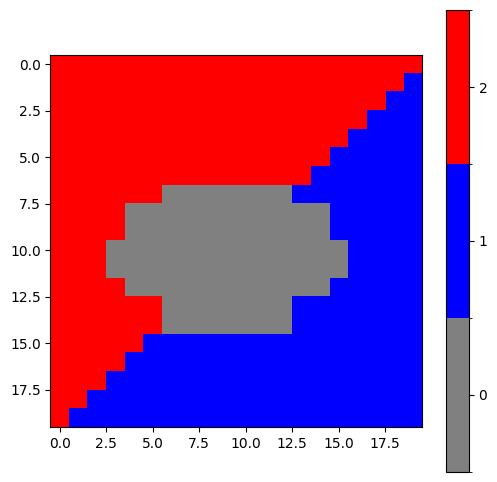

In [357]:
G = np.array([
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],

    [0,0,0,0,0,0,1,1,1,1,1,1,1,0,0,0,0,0,0,0],
    [0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0],
    [0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0],

    [0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0],
    [0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0],
    [0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0],
    [0,0,0,0,0,0,1,1,1,1,1,1,1,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,1,1,1,1,1,1,1,0,0,0,0,0,0,0],

    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
])

CG = colorize(G)
plot_color_graph(CG)

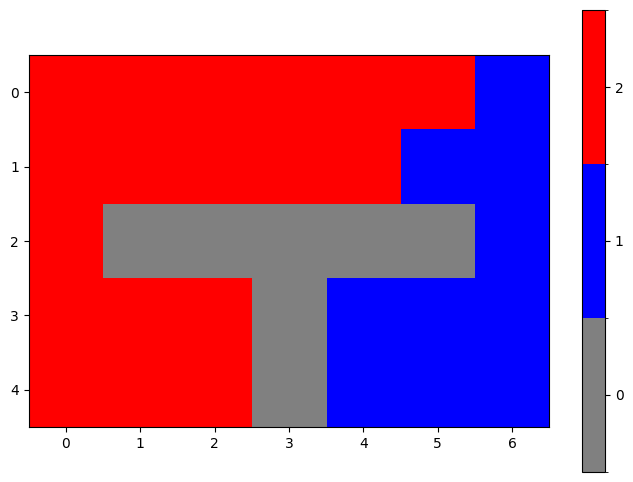

In [358]:
G2 = np.array([
    [0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0],
    [0,1,1,1,1,1,0],
    [0,0,0,1,0,0,0],
    [0,0,0,1,0,0,0]
])

CG2 = colorize(G2)
plot_color_graph(CG2)

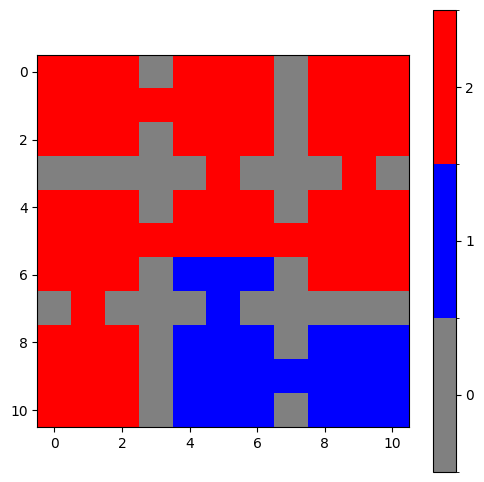

In [359]:
G3 = np.array([
    [0,0,0,1,0,0,0,1,0,0,0],
    [0,0,0,0,0,0,0,1,0,0,0],
    [0,0,0,1,0,0,0,1,0,0,0],
    [1,1,1,1,1,0,1,1,1,0,1],
    [0,0,0,1,0,0,0,1,0,0,0],
    [0,0,0,0,0,0,0,0,0,0,0],
    [0,0,0,1,0,0,0,1,0,0,0],
    [1,0,1,1,1,0,1,1,1,1,1],
    [0,0,0,1,0,0,0,1,0,0,0],
    [0,0,0,1,0,0,0,0,0,0,0],
    [0,0,0,1,0,0,0,1,0,0,0]
])

CG3 = colorize(G3)
plot_color_graph(CG3)

## Localizando com os Mapas

In [360]:
cell_size = 0.5

def sceneToGrid(coords):
    sx, sy = coords
    gx = int((sx+5) / cell_size)
    gy = int((sy+5) / cell_size)
    return gx, gy

def gridToScene(coords):
    gx, gy = coords
    sx = (gx * cell_size) - 5 + (cell_size/2)
    sy = (gy * cell_size) - 5 + (cell_size/2)
    return sx, sy

## Controle

In [379]:
def deLucaOriolo(force, theta):
    kv = 0.1
    kw = 0.01
    Fx, Fy = force

    v = kv*(Fx*np.cos(theta) + Fy*np.sin(theta))
    w = kw*(np.arctan2(Fy, Fx) - theta)

    return [v, w]

# Error between two angles (-PI,PI)
def angle_error(theta,alpha):
    if alpha < theta:
        (alpha,theta) = (theta,alpha)
    return min(alpha-theta,2*np.pi-alpha+theta)

def show_test(theta,alpha,expect):
    angle_err = angle_error(theta,alpha)
    diff = angle_err - expect
    print(f"theta={theta}")
    print(f"alpha={alpha}")
    print(f"angle_error={angle_err}")
    print(f"expect={expect}")
    print(f"diff={diff}")
    print()

show_test(-np.pi,np.pi,0)
show_test(0,np.pi,np.pi)
show_test(-np.pi,0,np.pi)
show_test(-np.pi/2,np.pi/2,np.pi)

theta=-3.141592653589793
alpha=3.141592653589793
angle_error=0.0
expect=0
diff=0.0

theta=0
alpha=3.141592653589793
angle_error=3.141592653589793
expect=3.141592653589793
diff=0.0

theta=-3.141592653589793
alpha=0
angle_error=3.141592653589793
expect=3.141592653589793
diff=0.0

theta=-1.5707963267948966
alpha=1.5707963267948966
angle_error=3.141592653589793
expect=3.141592653589793
diff=0.0



## Iniciando os Robôs

In [362]:
def Rz(theta):
    return np.array(
        [[np.cos(theta), -np.sin(theta), 0],
         [np.sin(theta), np.cos(theta), 0],
         [0, 0, 1]])


# ! GOAL OBJECT FOR DEBUGGING
goal_object = sim.getObject("/Goal")


class Robot():
    def __init__(self, name):
        self.name = name
        self.object = sim.getObject(f"/{name}")
        self.L = 0.230
        self.r = 0.03
        self.left_motor = sim.getObject(f"/{name}/kobuki_leftMotor")
        self.right_motor = sim.getObject(f"/{name}/kobuki_rightMotor")
        self.set_target_velocity(0, 0)

        self.ERROR_MARGIN = 0.2
        self.next_goals = []
        self.current_goal = None

        self.target_orientation = None
        self.last_location = None

    def differentialModel(self, v, w):
        wr = ((2.0*v) + (w*self.L)) / (2.0*self.r)
        wl = ((2.0*v) - (w*self.L)) / (2.0*self.r)
        return [wl, wr]

    def set_target_velocity(self, wl, wr):
        sim.setJointTargetVelocity(self.left_motor, wl)
        sim.setJointTargetVelocity(self.right_motor, wr)

    def get_current_position(self):
        pos = sim.getObjectPosition(self.object)
        ori = sim.getObjectOrientation(self.object)
        q = np.array([pos[0], pos[1], ori[2]])
        return q

    def get_current_location(self):
        q = self.get_current_position() + cell_size * np.array([0.5, 0.5, 0])
        return sceneToGrid(q[:2])

    def get_current_goal(self):
        if self.current_goal != None:
            return self.current_goal
        if len(self.next_goals) > 0:
            self.current_goal = self.next_goals.pop(0)
            print(f"[{self.name}] new goal is {self.current_goal}")
            (jg, ig) = self.current_goal
            (xg, yg) = gridToScene((jg, ig))
            q_goal = np.array([xg, yg, 0]) + cell_size * \
                np.array([0.5, 0.5, 0])
            sim.setObjectPosition(goal_object, [(q_goal[0]), (q_goal[1]), .2])
            print(f"set goal at {q_goal[0]} {q_goal[1]}")
            return self.current_goal
        return None

    def get_goal_location(self):
        return self.current_goal

    def get_goal_position(self):
        (jg, ig) = self.current_goal
        (xg, yg) = gridToScene((jg, ig))
        # Goal should be in the middle of cell
        q_goal = np.array([xg, yg, 0]) + cell_size * np.array([0.5, 0.5, 0])
        return q_goal

    def add_new_goals(self, new_goals):
        self.next_goals.extend(new_goals)

    def has_reached_goal(self):
        if self.current_goal == None:
            return True

        q = self.get_current_position()
        q_goal = self.get_goal_position()
        error = q_goal - q
        return np.linalg.norm(error) < self.ERROR_MARGIN

    def move_to_goal(self):
        if self.get_current_goal() == None:
            print(f"[{self.name}] has no goals.")
            return

        if self.has_reached_goal():
            print(f"[{self.name}] has reached goal {self.current_goal}")
            # if no new goal,
            if not self.next_goals:
                print(f"[{self.name}] has no new goals.")
                self.current_goal = None
                self.set_target_velocity(0, 0)
                return

            # find new goal
            self.current_goal = self.next_goals.pop(0)

            # ! DEBUG
            q_goal = self.get_goal_position()
            sim.setObjectPosition(goal_object, [(q_goal[0]), (q_goal[1]), .2])
            print(f"set goal at {q_goal[0]} {q_goal[1]}")

            print(f"[{self.name}] new goal is {self.current_goal}")
            print(f"[{self.name}] is at {self.get_current_location()}")

        theta = self.get_current_position()[2]
        print(f"theta={theta}")

        # If there is a target_orientaiton, just turn
        if self.target_orientation != None and abs(self.target_orientation - theta) > 0.1:
            # Turn around
            Max_theta = 1
            K_theta = 0.01
            delta_theta = theta- self.target_orientation 
            print("Turning around")

            # Cinematica inversa
            [wl, wr] = self.differentialModel(0, min(Max_theta,K_theta*delta_theta))

            # Enviando velocidades
            self.set_target_velocity(wl, wr)

            return

        # If this location is the same as last, keep moving forward
        current_location = self.get_current_location()
        if current_location == self.last_location:
            # Move forward
            print("Moving forward")

            # Cinematica inversa
            [wl, wr] = self.differentialModel(1, 0)

            # Enviando velocidades
            self.set_target_velocity(wl, wr)

            return

        # Update the target movements
        print("Updating target")
        (rj, ri) = current_location
        (gj, gi) = self.get_goal_location()
        (dj, di) = (gj-rj, gi-ri)

        if dj != 0:
            self.target_orientation = 0 if dj > 0 else np.pi
        else:
            self.target_orientation = np.pi / 2 if di > 0 else 3 * np.pi / 2

        print(f"target_orientation is {self.target_orientation}")
        self.last_location = current_location


walle = Robot("WALL_E")
# mo = Robot("M_O")
print(walle.name, walle.object, walle.left_motor, walle.right_motor)
# print(mo.name, mo.object, mo.left_motor, mo.right_motor)

WALL_E 116 128 133


## Controle para andar entre células

## Simulação

In [363]:
sim.stopSimulation()
sim.startSimulation()

MAX_SIMULATION_TIME = 600

# walle.add_new_goals([(15,15) ]) # ,(15,14),(15,13),(15,12),(14,12),(14,11)])

while (t := sim.getSimulationTime()) < MAX_SIMULATION_TIME:
    walle.move_to_goal()
    # break
    # mo.move_to_goal()
    sim.step()

sim.stopSimulation()

[WALL_E] new goal is (15, 15)
set goal at 3.0 3.0
theta=0.02978167796850233
Updating target
target_orientation is 3.141592653589793
theta=0.024955339665320424
Turning around
theta=0.17307659177953938
Turning around
theta=0.04447889206106438
Turning around
theta=0.33806746869680604
Turning around
theta=0.40868959935880494
Turning around
theta=0.39072017115056057
Turning around
theta=0.4018747811716746
Turning around
theta=0.48760561461715896
Turning around
theta=0.40646210973861
Turning around
theta=0.3424053769662318
Turning around
theta=0.34390176923723315
Turning around
theta=0.3278012927630538
Turning around
theta=0.24128244891673925
Turning around
theta=0.12899141340087206
Turning around
theta=0.31157951144754764
Turning around
theta=0.3057682752518158
Turning around
theta=0.29703205408807115
Turning around
theta=0.2906357992919213
Turning around
theta=0.27259024563052026
Turning around
theta=0.25990306554457265
Turning around
theta=0.2501973179344389
Turning around
theta=0.2436855

KeyboardInterrupt: 